# Comparisons

In [4]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import units as u
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import FluxPointsDataset, Datasets

## Comparing Swift data

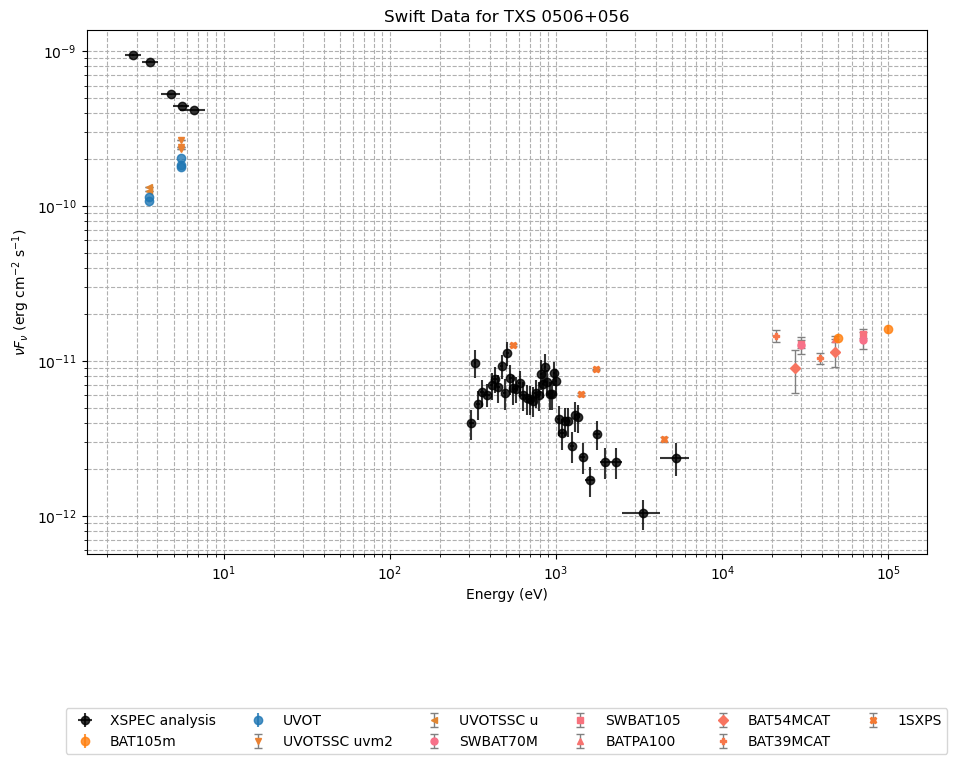

In [2]:
# Define marker styles and color palette
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*', 'h', 'H', '+', 'x', '|', '_']
palette = sns.color_palette("husl", 76)

# -----------------------
# 1. Swift Builder data
# -----------------------
builder_file = '/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_Builder.txt'
swift_keywords = ['SWBAT70M', 'SWBAT105', 'BATPA100', 'BAT54MCAT', 'BAT39MCAT', '1SXPS', 'UVOTSSC']

# Containers
data = []
upper_limit_data = []
dataset_labels = []
label_color_map = {}
label_marker_map = {}
current_label = None
color_index = 0
marker_index = 0

with open(builder_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    if line.startswith('#'):
        if 'id' in line:
            for keyword in swift_keywords:
                if keyword in line:
                    current_label = line.split('(')[0].strip().replace('#', '').strip()
                    if current_label not in dataset_labels:
                        dataset_labels.append(current_label)
                        label_color_map[current_label] = palette[color_index % len(palette)]
                        label_marker_map[current_label] = markers[marker_index % len(markers)]
                        color_index += 1
                        marker_index += 1
                    break
            else:
                current_label = None
        continue

    if current_label:
        parts = line.split()
        if len(parts) >= 6:
            try:
                energy = float(parts[0])
                flux = float(parts[2])
                flux_err = float(parts[3])
                if 'UPPER LIMIT' in line:
                    upper_limit_data.append([energy, flux, flux_err, current_label])
                else:
                    data.append([energy, flux, flux_err, current_label])
            except ValueError:
                continue

# Convert Builder data to DataFrames
df_builder = pd.DataFrame(data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])
upper_limit_df = pd.DataFrame(upper_limit_data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])

# -----------------------
# 2. XSPEC QDP spectrum
# -----------------------
qdp_file = '/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/mydata2.qdp'
colnames = ['energy', 'denergy', 'flux', 'flux_err', 'model_flux']
df_unfolded = pd.read_table(qdp_file, skiprows=3, names=colnames, sep='\s+')
df_unfolded.replace('NO', np.nan, inplace=True)
df_plot = df_unfolded.apply(pd.to_numeric)

energy_Hz = df_plot['energy'].values * u.Hz
denergy_Hz = df_plot['denergy'].values * u.Hz
energy_eV = energy_Hz.to(u.eV, equivalencies=u.spectral())
denergy_eV = denergy_Hz.to(u.eV, equivalencies=u.spectral())

# Identify the row with the largest error
idx_outlier = df_plot['flux_err'].idxmax()

# Drop that row from df_plot and the corresponding entries in energy and denergy
df_plot = df_plot.drop(idx_outlier).reset_index(drop=True)
energy_eV = np.delete(energy_eV, idx_outlier)
denergy_eV = np.delete(denergy_eV, idx_outlier)

# Step 2: Load MMDC Swift data
csv_file = '/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_complete.csv'
df_mmdc = pd.read_csv(csv_file)
swift_catalogs = ['UVOT', 'BAT105m']
swift_data_mmdc = df_mmdc[df_mmdc['catalog'].isin(swift_catalogs)]

# -----------------------
# 3. Plotting
# -----------------------
plt.figure(figsize=(10, 8))

# Plot Swift Builder detections
for dataset in np.unique(df_builder['Dataset']):
    subset = df_builder[df_builder['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 fmt=label_marker_map[dataset], markersize=5, capsize=3,
                 color=label_color_map[dataset], ecolor='gray', elinewidth=1,
                 label=dataset)

# Plot Swift Builder upper limits
for dataset in np.unique(upper_limit_df['Dataset']):
    subset = upper_limit_df[upper_limit_df['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 xerr=0.2 * subset['Energy'], uplims=True, capsize=3,
                 fmt=label_marker_map[dataset],
                 color=label_color_map[dataset], label=None)

# Plot Swift MMDC data by catalog
for cat in swift_catalogs:
    subset = swift_data_mmdc[swift_data_mmdc['catalog'] == cat]
    if not subset.empty:
        plt.errorbar(
            subset['frequency'], subset['flux'],
            yerr=subset['flux_err'],
            fmt='o', label=cat, alpha=0.8
        )

# Plot XSPEC spectrum
plt.errorbar(
    energy_eV.value, df_plot['flux'],
    xerr=denergy_eV.value, yerr=df_plot['flux_err'],
    fmt='o', color='black', alpha=0.8, label='XSPEC analysis'
)

# Final formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_\nu$ (erg cm$^{-2}$ s$^{-1}$)')
plt.title('Swift Data for TXS 0506+056')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper center',
           bbox_to_anchor=(0.5, -0.28), ncol=6)
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()

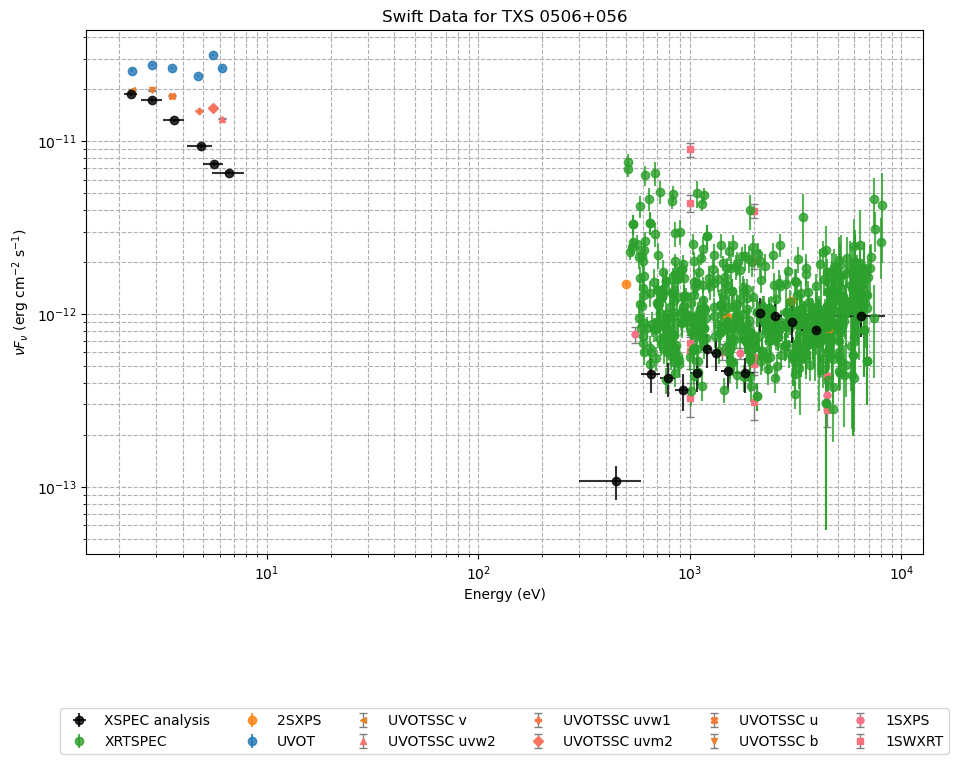

In [3]:
# Define marker styles and color palette
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*', 'h', 'H', '+', 'x', '|', '_']
palette = sns.color_palette("husl", 76)

# -----------------------
# 1. Swift Builder data
# -----------------------
builder_file = '/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/TXS/TXS0506056_Builder.txt'
swift_keywords = ['SWBAT70M', 'SWBAT105', 'BATPA100', 'BAT54MCAT', 'BAT39MCAT', '1SXPS', 'UVOTSSC', '1SWXRT']

# Containers
data = []
upper_limit_data = []
dataset_labels = []
label_color_map = {}
label_marker_map = {}
current_label = None
color_index = 0
marker_index = 0

with open(builder_file, 'r') as f:
    lines = f.readlines()

for line in lines:
    if line.startswith('#'):
        if 'id' in line:
            for keyword in swift_keywords:
                if keyword in line:
                    current_label = line.split('(')[0].strip().replace('#', '').strip()
                    if current_label not in dataset_labels:
                        dataset_labels.append(current_label)
                        label_color_map[current_label] = palette[color_index % len(palette)]
                        label_marker_map[current_label] = markers[marker_index % len(markers)]
                        color_index += 1
                        marker_index += 1
                    break
            else:
                current_label = None
        continue

    if current_label:
        parts = line.split()
        if len(parts) >= 6:
            try:
                energy = float(parts[0])
                flux = float(parts[2])
                flux_err = float(parts[3])
                if 'UPPER LIMIT' in line:
                    upper_limit_data.append([energy, flux, flux_err, current_label])
                else:
                    data.append([energy, flux, flux_err, current_label])
            except ValueError:
                continue

# Convert Builder data to DataFrames
df_builder = pd.DataFrame(data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])
upper_limit_df = pd.DataFrame(upper_limit_data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])

# -----------------------
# 2. XSPEC QDP spectrum
# -----------------------
qdp_file = '/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/TXS/mydata3.qdp'
colnames = ['energy', 'denergy', 'flux', 'flux_err', 'model_flux']
df_unfolded = pd.read_table(qdp_file, skiprows=3, names=colnames, sep='\s+')
df_unfolded.replace('NO', np.nan, inplace=True)
df_plot = df_unfolded.apply(pd.to_numeric)

energy_Hz = df_plot['energy'].values * u.Hz
denergy_Hz = df_plot['denergy'].values * u.Hz
energy_eV = energy_Hz.to(u.eV, equivalencies=u.spectral())
denergy_eV = denergy_Hz.to(u.eV, equivalencies=u.spectral())

# Step 2: Load MMDC Swift data
csv_file = '/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/TXS/TXS0506+056_complete.csv'
df_mmdc = pd.read_csv(csv_file)
swift_catalogs = ['UVOT', 'BAT105m', '2SXPS', 'XRTSPEC']
swift_data_mmdc = df_mmdc[df_mmdc['catalog'].isin(swift_catalogs)]

# -----------------------
# 3. Plotting
# -----------------------
plt.figure(figsize=(10, 8))

# Plot Swift Builder detections
for dataset in np.unique(df_builder['Dataset']):
    subset = df_builder[df_builder['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 fmt=label_marker_map[dataset], markersize=5, capsize=3,
                 color=label_color_map[dataset], ecolor='gray', elinewidth=1,
                 label=dataset)

# Plot Swift Builder upper limits
for dataset in np.unique(upper_limit_df['Dataset']):
    subset = upper_limit_df[upper_limit_df['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 xerr=0.2 * subset['Energy'], uplims=True, capsize=3,
                 fmt=label_marker_map[dataset],
                 color=label_color_map[dataset], label=None)

# Plot Swift MMDC data by catalog
for cat in swift_catalogs:
    subset = swift_data_mmdc[swift_data_mmdc['catalog'] == cat]
    if not subset.empty:
        plt.errorbar(
            subset['frequency'], subset['flux'],
            yerr=subset['flux_err'],
            fmt='o', label=cat, alpha=0.8
        )

# Plot XSPEC spectrum
plt.errorbar(
    energy_eV.value, df_plot['flux'],
    xerr=denergy_eV.value, yerr=df_plot['flux_err'],
    fmt='o', color='black', alpha=0.8, label='XSPEC analysis'
)

# Final formatting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_\nu$ (erg cm$^{-2}$ s$^{-1}$)')
plt.title('Swift Data for TXS 0506+056')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper center',
           bbox_to_anchor=(0.5, -0.28), ncol=6)
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


## Both objects

/var/folders/d2/vc9_lbj902b8n1wlkbw8c1mr0000gn/T/ipykernel_41135/1023254784.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_ul = pd.read_csv('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_MAGIC_UL.dat', delim_whitespace=True, header=0)


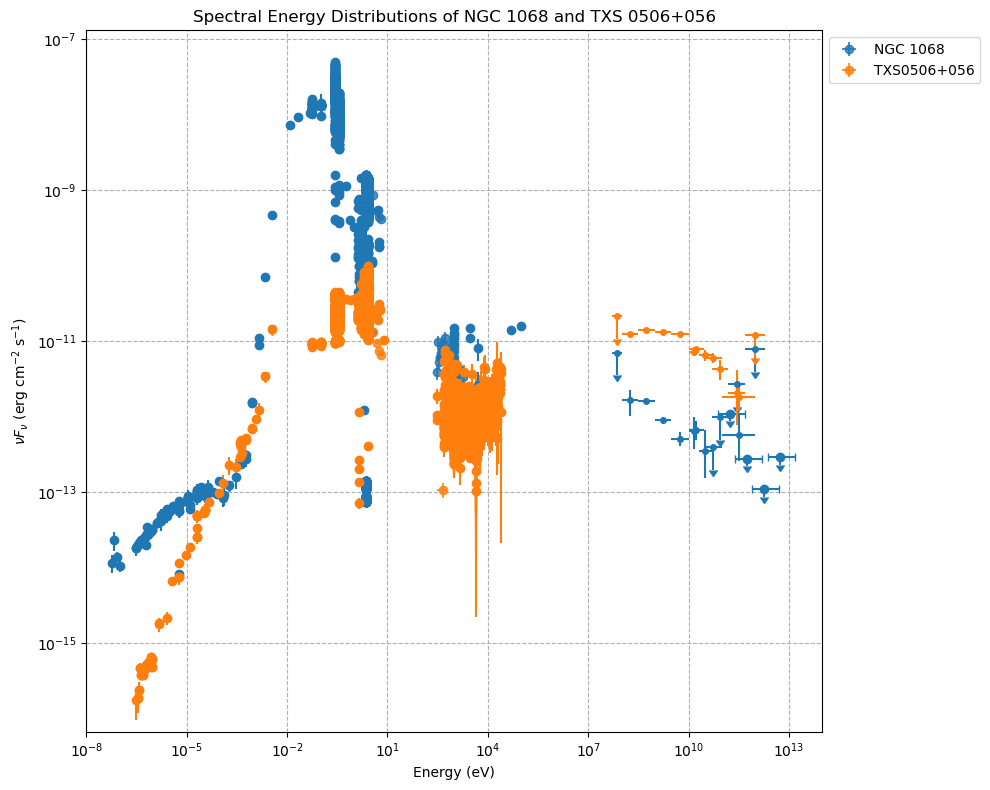

In [5]:
fraction = 0.2  # 20% of the flux, for example

# Define column names for the unfolded spectrum
column_names = ['energy', 'denergy', 'flux', 'flux_err', 'model_flux']

# Read the QDP file, fixing the deprecation warning
df_unfolded = pd.read_table('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/mydata2.qdp', skiprows=3, names=column_names, sep='\s+')

# Replace 'NO' values with NaN and convert columns to numeric
df_unfolded.replace('NO', np.nan, inplace=True)
df_unfolded = df_unfolded.apply(pd.to_numeric)

# Identify the row with the largest error
idx_outlier = df_unfolded['flux_err'].idxmax()

# Drop that row from the DataFrame
df_plot = df_unfolded.drop(idx_outlier)

# Convert entire Series into Quantity objects before calling .to()
energy_Hz = df_plot['energy'].values * u.Hz
denergy_Hz = df_plot['denergy'].values * u.Hz

# Convert Hz -> eV
energy_eV = energy_Hz.to(u.eV, equivalencies=u.spectral())
denergy_eV = denergy_Hz.to(u.eV, equivalencies=u.spectral())

#Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()

source_fermi_4fgl = catalog_4fgl["4FGL J0242.6-0000"]
source_fermi_3fhl = catalog_3fhl["3FHL J0242.7-0002"]

dataset_4fgl = FluxPointsDataset(data=source_fermi_4fgl.flux_points, name="Fermi 4FGL-DR4")
dataset_4fgl.data.to_table(sed_type="dnde", formatted=True)

dataset_3fhl = FluxPointsDataset(data=source_fermi_3fhl.flux_points, name="Fermi 3FHL")
dataset_3fhl.data.to_table(sed_type="dnde", formatted=True)

datasets = Datasets([dataset_4fgl, dataset_3fhl])

# Read the .dat file assuming whitespace-separated values.
df_ul = pd.read_csv('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_MAGIC_UL.dat', delim_whitespace=True, header=0)

# Rename columns for clarity
df_ul.columns = ['energy', 'energy_min', 'energy_max', 'flux_UL']

# Convert columns to numeric
df_ul['energy'] = pd.to_numeric(df_ul['energy'], errors='coerce')
df_ul['energy_min'] = pd.to_numeric(df_ul['energy_min'], errors='coerce')
df_ul['energy_max'] = pd.to_numeric(df_ul['energy_max'], errors='coerce')
df_ul['flux_UL'] = pd.to_numeric(df_ul['flux_UL'], errors='coerce')

# Convert MAGIC energy from GeV to eV (1 GeV = 1e9 eV)
df_ul['energy'] = df_ul['energy'] * 1e9
df_ul['energy_min'] = df_ul['energy_min'] * 1e9
df_ul['energy_max'] = df_ul['energy_max'] * 1e9

# Read the CSV file
df_x = pd.read_csv('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/NGC 1068/NGC1068_xray.csv')

# Filter out rows where the catalog is 'Chandra-CSC2'
df_x = df_x[df_x['catalog'] != 'Chandra-CSC2']
# Get unique catalogs from the filtered DataFrame
catalogs = df_x['catalog'].unique()

# Create a combined plot
fig, ax = plt.subplots(figsize=(10, 8))
# Set x-axis units to eV so that the Fermi plot (which uses eV) aligns correctly
ax.xaxis.set_units(u.Unit("eV"))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color='#1f77b4')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color='#1f77b4', uplims=True)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_plot['flux'],
            xerr=denergy_eV.value, yerr=df_plot['flux_err'],
            fmt='o', color='#1f77b4', alpha=0.8, label='NGC 1068')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(**kwargs, color='#1f77b4')

# Plot MAGIC upper limits
# Use uplims=True to draw a downward arrow from the data point
plt.errorbar(
    df_ul['energy'],
    df_ul['flux_UL'],
    yerr = fraction * df_ul['flux_UL'],
    xerr=[df_ul['energy_min'], df_ul['energy_max']],
    fmt='o',         # 'o' marker at the flux limit
    uplims=True,     # arrow indicates flux is only bounded from above
    color='#1f77b4',
    capsize=3,       # length of the error bar caps
)

# Define column names for the unfolded spectrum
column_names = ['energy', 'denergy', 'flux', 'flux_err', 'model_flux']

# Read the QDP file, fixing the deprecation warning
df_unfolded = pd.read_table('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/TXS/mydata3.qdp', skiprows=3, names=column_names, sep='\s+')

# Replace 'NO' values with NaN and convert columns to numeric
df_unfolded.replace('NO', np.nan, inplace=True)
df_unfolded = df_unfolded.apply(pd.to_numeric)

# Convert entire Series into Quantity objects before calling .to()
energy_Hz = df_unfolded['energy'].values * u.Hz
denergy_Hz = df_unfolded['denergy'].values * u.Hz

# Convert Hz -> eV
energy_eV = energy_Hz.to(u.eV, equivalencies=u.spectral())
denergy_eV = denergy_Hz.to(u.eV, equivalencies=u.spectral())

#Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()

source_fermi_4fgl = catalog_4fgl["4FGL J0509.4+0542"]
source_fermi_3fhl = catalog_3fhl["3FHL J0509.4+0542"]

dataset_4fgl = FluxPointsDataset(data=source_fermi_4fgl.flux_points, name="4fgl")
dataset_4fgl.data.to_table(sed_type="dnde", formatted=True)

dataset_3fhl = FluxPointsDataset(data=source_fermi_3fhl.flux_points, name="3fhl")
dataset_3fhl.data.to_table(sed_type="dnde", formatted=True)

datasets = Datasets([dataset_4fgl, dataset_3fhl])

# Read the CSV file
df_x = pd.read_csv('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/SED/TXS/TXS0506+056_xray.csv')
# Get unique catalogs
catalogs = df_x['catalog'].unique()

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color='#ff7f0e')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color='#ff7f0e', uplims=True)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_unfolded['flux'],
            xerr=denergy_eV.value, yerr=df_unfolded['flux_err'],
            fmt='o', color='#ff7f0e', alpha=0.8, label='TXS0506+056')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(color='#ff7f0e', **kwargs)

# Adjust axis limits to cover the full energy range
ax.set_xlim(1e-8, 1e14)

# Set labels and title
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
ax.set_title('Spectral Energy Distributions of NGC 1068 and TXS 0506+056')
plt.grid(True, which='both', linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)

plt.tight_layout()
plt.show()